This notebook contains code for running basic time series analysis on the energy generated data.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import datetime   # package that helps manipulate dates

#for decomposition:
from statsmodels.tsa.seasonal import seasonal_decompose

# for simple exponential smoothing
#from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# used for autocorrelation
import statsmodels.api as sm

# measuring MAE and RMSE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [7]:
# increase figure size
plt.rcParams['figure.figsize'] = [12, 8]

In [8]:
#Importing data and cleaning to make a nice df with 2 columns

# import data (file and path are not from github, just downloaded because git stuff wasn't completed yet)
df = pd.read_csv("./nrg_gen_full_daily.csv")

#renaming the columns we want to actually keep 
df.rename(columns={
        'Data Dica': 'date', 
        'Selecione Tipo de GE Simp 4': 'energy_generated'
    }, inplace=True)

#Creating list of all columns we want to delete (gotten in separate cell using df.columns)
badcols = ['Data Escala de Tempo 1 GE Simp 4',
       'cod_aneel (tb_referenciacegusina (Usina))',
       'cod_nucleoaneel (tb_referenciacegusina (Usina))',
       'dsc_estado', 'id_subsistema', 'nom_tipousinasite', 'nom_usina2',
       'Período Exibido GE']
#actually deleting those unnecessary columns
for col in badcols:
    del df[col]
    
# turn "date" into a quantifiable object
df["date"] = pd.to_datetime(df["date"],format = '%d/%m/%Y')  


In [9]:
print(pd.date_range(
  start="1999-01-01", end="2021-04-03").difference(df['date']))

DatetimeIndex(['2014-02-01'], dtype='datetime64[ns]', freq=None)


above line demonstrates that we are missing one data point.  That can fuck with time series stuff, so we will interpolate it (average of nearest points)

In [10]:
df.tail()

,date,energy_generated
8223,2021-07-08,0.385300
8224,2021-07-09,0.384876
8225,2021-07-10,0.385317
8226,2021-07-11,0.385480
8227,2021-07-12,0.385028


In [11]:
# get the days next to the missing day
near_days = df[(df['date'] == '2014-01-31') | (df['date'] == '2020-02-02')].copy()

# take mean of these values
missing_day = np.mean(near_days['energy_generated'])

# indexing set
idx = pd.date_range(start="1999-01-01", end="2021-07-12")

# making df indexed by date
df.index = pd.DatetimeIndex(df['date'])

# reindexing to include missing day, filled with average of nearby days
df = df.reindex(idx, fill_value=missing_day)


# for some reason, above reindex makes the date column crazy... but we don't need it anymore since date is now the index column
df['date'] = df.index 
df["date"] = pd.to_datetime(df["date"],format = '%Y-%m-%d')  

# df = df.drop(labels='date', axis=1)
df.head()

,date,energy_generated
1999-01-01,1999-01-01,2.7324
1999-01-02,1999-01-02,2.7371
1999-01-03,1999-01-03,2.5538
1999-01-04,1999-01-04,2.6530
1999-01-05,1999-01-05,2.5833


In [12]:
df[(df.index >= '2014-01-31') & (df.index <= '2014-02-02')]

,date,energy_generated
2014-01-31,2014-01-31,1.441500
2014-02-01,2014-02-01,0.973142
2014-02-02,2014-02-02,0.545340


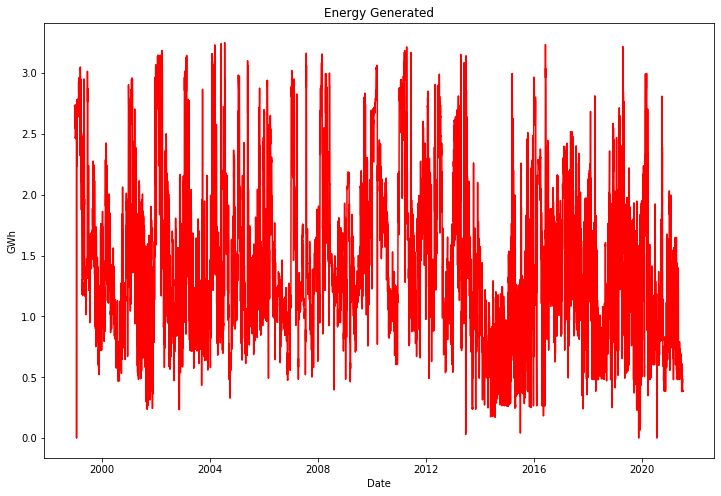

In [13]:
#plotting energy generated over full time period
plt.plot(df.index, df.energy_generated[:], 'r')   
plt.title('Energy Generated')
# Units not in GWh
plt.ylabel('GWh');
plt.xlabel('Date');
plt.show();

In the next cell we are doing the basic time series decomposition that was demonstrated in class

the results are not fruitful

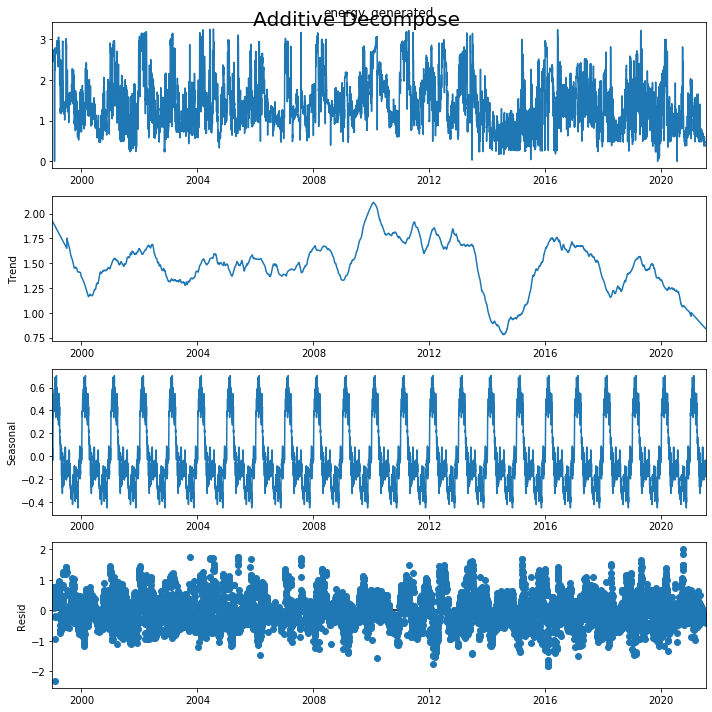

In [14]:


# Must choose a period for the decomposition; here choosing an annual one
# Multiplicative Decomposition:  Returns seasonal, trend, and resid attributes
result_mul = seasonal_decompose(df['energy_generated'] + 0.0001, model='multiplicative', extrapolate_trend='freq', period=365)

# Additive Decomposition
result_add = seasonal_decompose(df['energy_generated'], model='additive', extrapolate_trend='freq', period=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=20)
result_add.plot().suptitle('Additive Decompose', fontsize=20)
plt.savefig('foo.png')
plt.show()

Checking autocorrelation

In [15]:
#calculate autocorrelations
# nlags is how many lags to compute
sm.tsa.acf(df['energy_generated'], nlags = 121)
#sm.tsa.acf(df['energy_generated'], nlags = 10)


/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


array([ 1.        ,  0.86230368,  0.79048283,  0.75015059,  0.7120497 ,
        0.67785029,  0.66565274,  0.6776666 ,  0.60982742,  0.56751288,
        0.54638405,  0.530271  ,  0.51757292,  0.51930581,  0.54352693,
        0.49694369,  0.46896791,  0.45781014,  0.4454458 ,  0.43639902,
        0.44405913,  0.46717419,  0.41979566,  0.39260805,  0.3805807 ,
        0.37030105,  0.36397971,  0.37412099,  0.4001625 ,  0.35830816,
        0.33688131,  0.33120728,  0.33165575,  0.32835742,  0.33849786,
        0.3658795 ,  0.32666205,  0.30680963,  0.30311134,  0.30107813,
        0.30024208,  0.31454742,  0.34536732,  0.30865412,  0.2894786 ,
        0.28599289,  0.28224004,  0.27853143,  0.28981122,  0.31764527,
        0.27675433,  0.25747485,  0.25270261,  0.24987399,  0.24318156,
        0.25063207,  0.27524311,  0.2350305 ,  0.21205088,  0.20608058,
        0.20052724,  0.19360523,  0.19993975,  0.22324137,  0.18565741,
        0.16862828,  0.16426775,  0.15943067,  0.15218458,  0.15

From autocorrelation output above, we see that the autocorrelation is weak (just gets weaker and weaker as time goes back), and there doesn't seem to be any seasonality.  

The following code checks that lack of seasonality

Let's do some windowing, and see if we can extract better patterns from smaller subsets

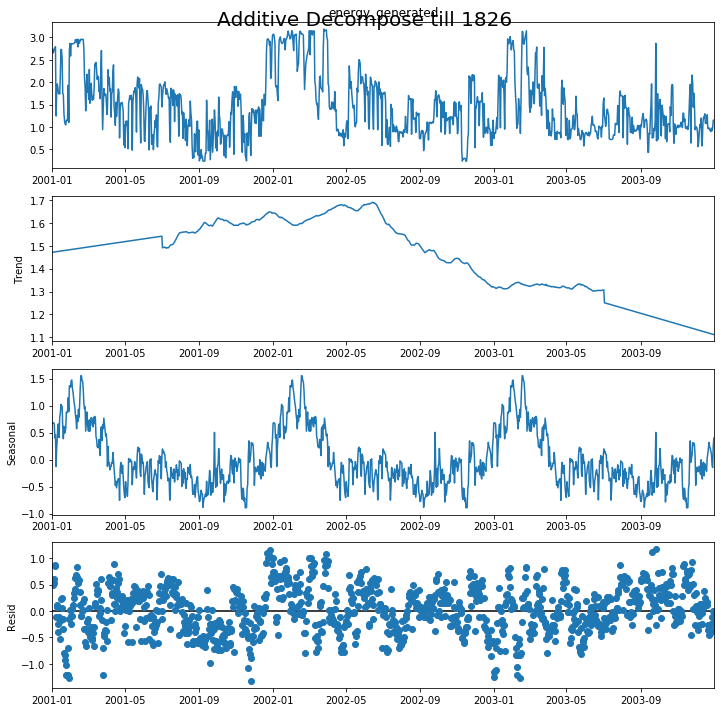

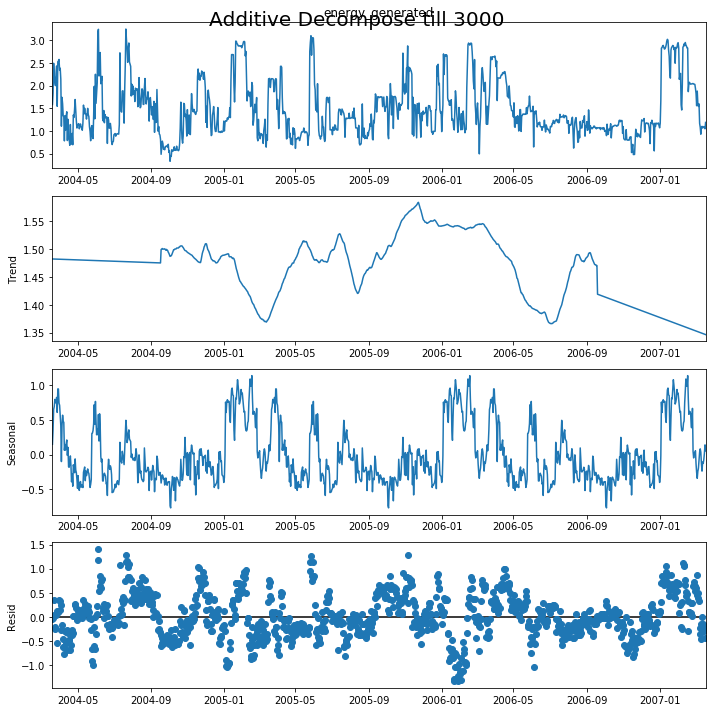

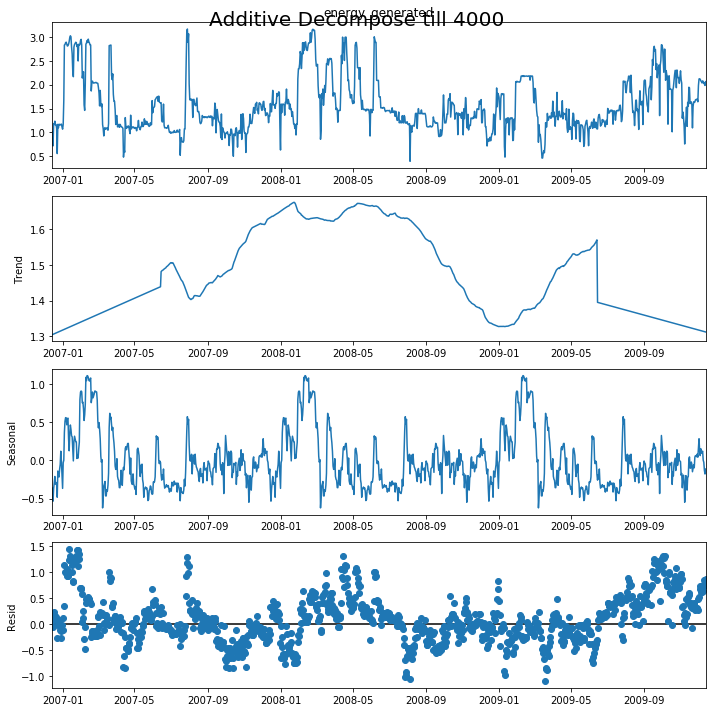

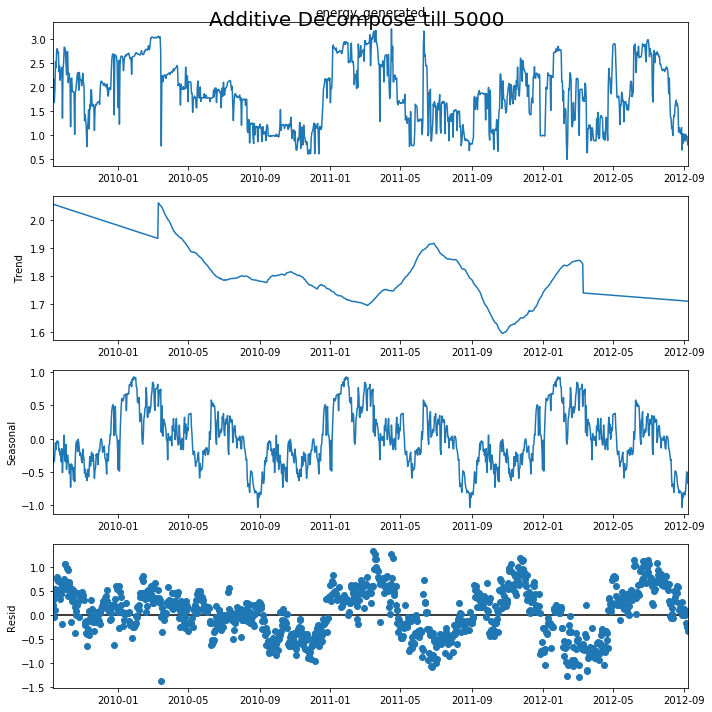

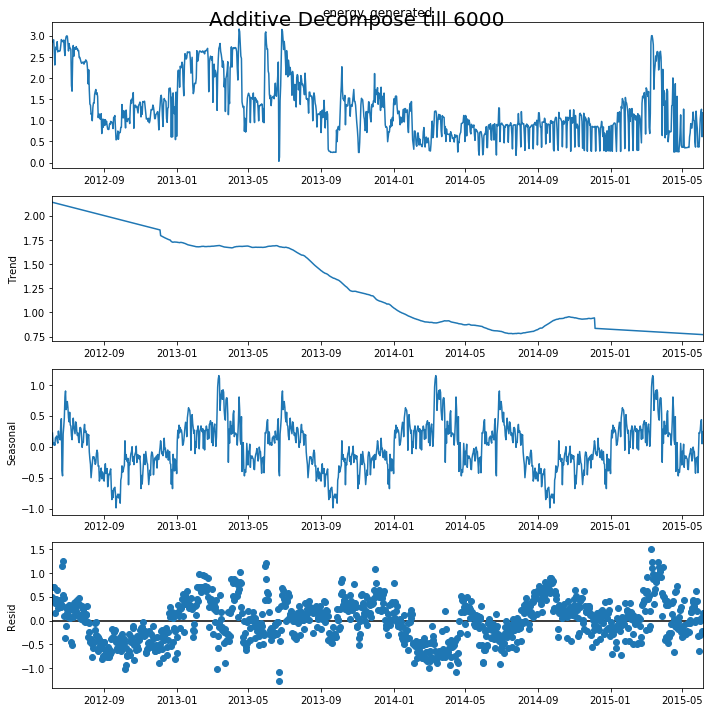

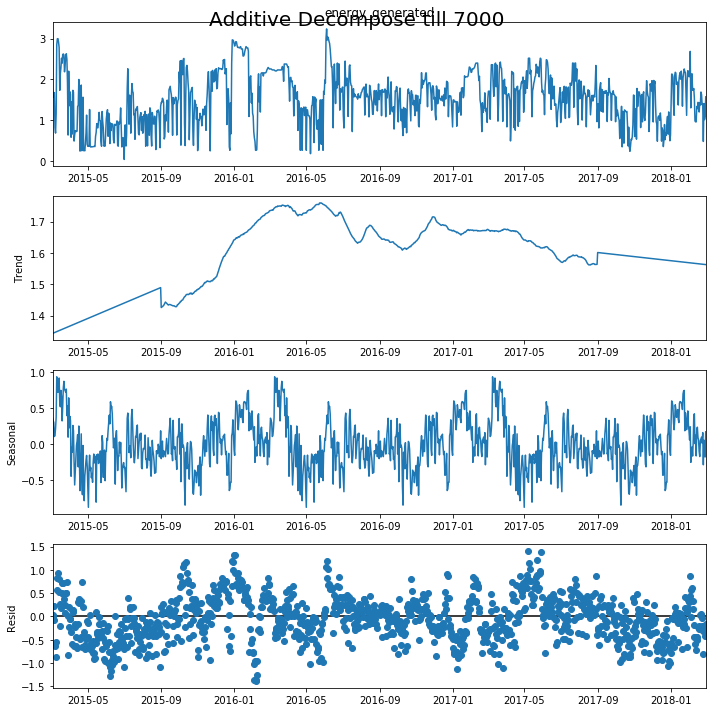

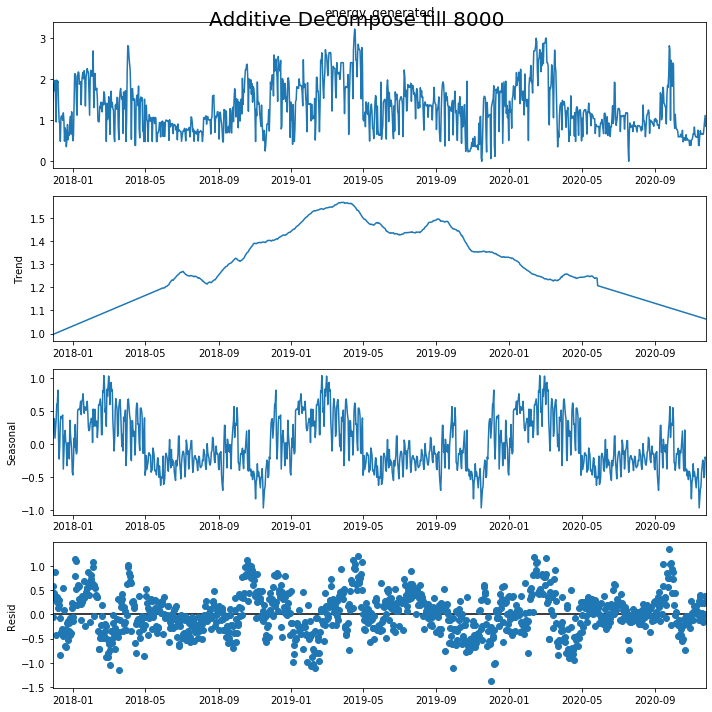

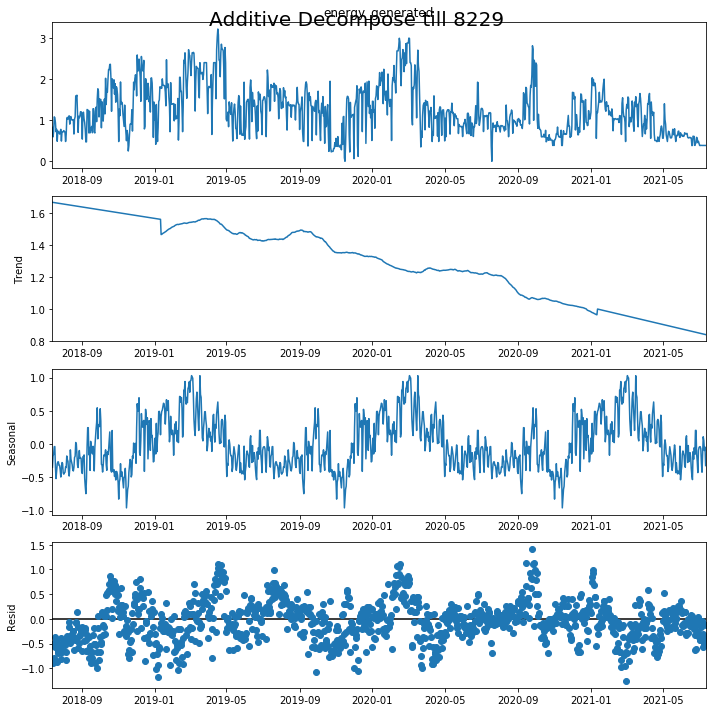

In [16]:
# Multiplicative Decomposition:  Returns seasonal, trend, and resid attributes
#Choose periodicity of seasonality (currently 365 days naively)
per = 365
# how long of a window to examine over
win_length = 365*3
# ending point (should figure out how to put in dates here more directly at some point)
# these are pretty randomly chosen, should also see if I can pick some better windows by eye or by historical/weather events
end_points = [1826, 3000, 4000, 5000, 6000, 7000, 8000, len(df)]

for ends in end_points:
    
    #result_mul = seasonal_decompose(df.iloc[(ends-win_length):ends,1] + 0.0001, model='multiplicative', extrapolate_trend='freq', period=per)

    # Additive Decomposition
    result_add = seasonal_decompose(df.iloc[(ends-win_length):ends,1], model='additive', extrapolate_trend='freq', period=per)

    # Plot
    plt.rcParams.update({'figure.figsize': (10,10)})
    #result_mul.plot().suptitle('Multiplicative Decompose till %i' %ends, fontsize=20)
    result_add.plot().suptitle('Additive Decompose till %i' %ends, fontsize=20)
    plt.savefig('foo.png')
    plt.show()

For this next segment, I want to run through some extremely naive prediction methods.  Basically, gonna  (1) seasonal naive, and (2) slightly less naive seasonal method by averaging of that day in history.  In the future, would like to (3) predict things with regressions using season as dummy variables, but haven't done that yet.

In [17]:
# create train/test split 

# identify how many days in advance we would like to predict
pred_length = 30

# New data frame excluding the days that we want to predict
train = df.iloc[:len(df)-pred_length,1]
# The actual data that we aim to reproduce
test = df.iloc[len(df)-pred_length:, 1]




Up first is seasonal naive method

Description: https://otexts.com/fpp2/simple-methods.html

Implementation found here: https://pawarbi.github.io/blog/forecasting/r/python/rpy2/altair/fbprophet/ensemble_forecast/uncertainty/simulation/2020/04/21/timeseries-part2.html#Seasonal-Naive

Seems above place is going through the same book and implementing the methods in python

Update: that implementation seems wrong (or I'm misunderstanding the inputs) so I'm gonna just do my own thing

In [18]:
# Function to do basic seasonal naive method

def seasonal_naive(time_data, pred_length):
    '''
    This function implements the seasonal naive method for daily input data
    not a robust function, basically made for our problem with the energy generation
    Basically for each day we want to predict, we just guess the same output as last year
    Also checks MAE of this prediction
    
    Packages Required:
    >>> from sklearn.metrics import mean_absolute_error
    
    Returns 
        preds: an array of the predicted values
        pred_mae: Mean absolute error of the predictions
    
    Inputs:
        time_data: Pand series
            all the relevant data, including that which we want to predict
        pred_length: integer
            number of days we would like to predict
    '''
    
    # New series excluding the days that we want to predict
    train = time_data[:-pred_length]
    # The actual data that we aim to reproduce
    test = time_data[-pred_length:]
    
    # select the predicted values
    preds = train[-365:-365+ pred_length]
    
    #compute MAE
    mae = mean_absolute_error(preds,test)
    
    return preds, mae

In [19]:
# checking results of seasonal naive method
seasonal_naive(df['energy_generated'],100)

(2020-04-04    1.137405
 2020-04-05    0.827762
 2020-04-06    1.219770
 2020-04-07    1.204459
 2020-04-08    1.310745
                 ...   
 2020-07-08    1.087932
 2020-07-09    1.095004
 2020-07-10    1.114846
 2020-07-11    1.110785
 2020-07-12    0.782205
 Freq: D, Name: energy_generated, Length: 100, dtype: float64,
 0.4315750599999999)

Seasonal naive method has some serious errors, so let's try something a little bit (but not much) more sophisticated: guess each day is the average of power output on that day in previous years

In [20]:
def day_mean_forecast(df, pred_length):
    '''
    Makes a forecast by guessing that output of that day will be the average of the output on same day days in previous years
    Also checks MAE of this prediction
    
    Packages Required:
    from sklearn.metrics import mean_absolute_error
    pandas
    numpy
    
    Returns 
        preds: an array of the predicted values
        pred_mae: Mean absolute error of the predictions
    
    Inputs:
        df: 2xn Pandas dataframe
            first column is dates (Y-m-d) (must be labelled 'date' at this point)
            second column is relevant time series data
        pred_length: integer
            number of days we would like to predict
    '''
    
    # adding columns of which month and day-of-month for each entry to df
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['day'] = pd.DatetimeIndex(df['date']).day
    
    
    # New data frame excluding the days that we want to predict
    train = df.iloc[:-pred_length,:]
    # The actual data that we aim to reproduce
    test = df.iloc[-pred_length:, :]
    
    #setup for predicted values
    preds = test.copy()
    
    # predicted energy_generated is average
    for n in preds.index:
        this_date_in = train[(train['month'] == preds['month'][n]) & (train['day'] == preds['day'][n])]
        preds['energy_generated'][n] = np.mean(this_date_in['energy_generated'])
        
    
    #compute MAE
    mae = mean_absolute_error(preds['energy_generated'],test['energy_generated'])
    
    return preds, mae

In [21]:
day_mean_forecast(df,100)

/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(                 date  energy_generated  month  day
 2021-04-04 2021-04-04          1.607953      4    4
 2021-04-05 2021-04-05          1.679210      4    5
 2021-04-06 2021-04-06          1.706616      4    6
 2021-04-07 2021-04-07          1.616684      4    7
 2021-04-08 2021-04-08          1.511599      4    8
 ...               ...               ...    ...  ...
 2021-07-08 2021-07-08          1.430186      7    8
 2021-07-09 2021-07-09          1.328364      7    9
 2021-07-10 2021-07-10          1.381727      7   10
 2021-07-11 2021-07-11          1.450906      7   11
 2021-07-12 2021-07-12          1.420313      7   12
 
 [100 rows x 4 columns],
 0.7493015189863635)

Since our data lacks clear trend/seasonality, let's try Seasonal Exponential Smoothing.

Modifying tutorials found at https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline

/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


We are predicting 100 days in advance
MAE of alpha1=0.2  is 0.37906478831856  and RMSE is 0.4032301549590634
MAE of alpha2=0.6  is 0.3562920949771204  and RMSE is 0.3812196709170604
MAE of alpha3=0.6303559342874882  is 0.35888424031070726  and RMSE is 0.3836642530110296


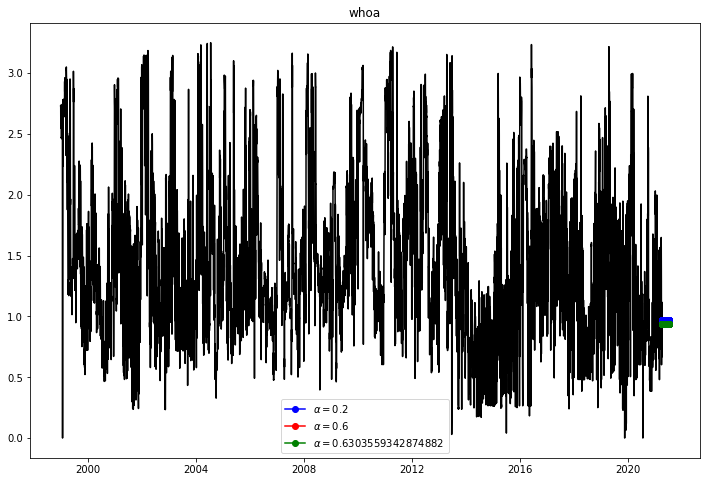

In [23]:
# Simple exponential smoothing

pred_length = 100

#train/test split
train = df.iloc[:-pred_length,:]
test = df.iloc[-pred_length:, :]

data = list(train['energy_generated'])
date_info = train['date'].copy()
date_info.name = None
index= pd.to_datetime(date_info,format = '%Y/%m/%d')
data = pd.Series(data, index)

alpha1 = 0.2
alpha2 = 0.6

fit1 = SimpleExpSmoothing(data, initialization_method="heuristic").fit(smoothing_level=alpha1,optimized=False)
fcast1 = fit1.forecast(pred_length).rename(r'$\alpha=%s$' %alpha1)
fit2 = SimpleExpSmoothing(data, initialization_method="heuristic").fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(pred_length).rename(r'$\alpha=%s$' %alpha2)
fit3 = SimpleExpSmoothing(data, initialization_method="estimated").fit()
fcast3 = fit3.forecast(pred_length).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])

plt.figure(figsize=(12, 8))
plt.plot(data, color='black')
#plt.plot(fit1.fittedvalues, marker='o', color='blue')
line1, = plt.plot(fcast1, marker='o', color='blue')
#plt.plot(fit2.fittedvalues, marker='o', color='red')
line2, = plt.plot(fcast2, marker='o', color='red')
#plt.plot(fit3.fittedvalues, marker='o', color='green')
line3, = plt.plot(fcast3, marker='o', color='green')
plt.title('whoa')
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

print('We are predicting %s days in advance' %pred_length)

mae1 = mean_absolute_error(fcast1,test['energy_generated'])
rmse1 = mean_squared_error(fcast1,test['energy_generated'], squared=False)
print('MAE of alpha1=%s ' %alpha1, 'is %s' %mae1, ' and RMSE is %s' %rmse1)

mae2 = mean_absolute_error(fcast2,test['energy_generated'])
rmse2 = mean_squared_error(fcast2,test['energy_generated'], squared=False)
print('MAE of alpha2=%s ' %alpha2, 'is %s' %mae2, ' and RMSE is %s' %rmse2)

mae3 = mean_absolute_error(fcast3,test['energy_generated'])
rmse3 = mean_squared_error(fcast3,test['energy_generated'], squared=False)
print('MAE of alpha3=%s ' %fit3.model.params['smoothing_level'], 'is %s' %mae3, ' and RMSE is %s' %rmse3)

Now doing exponential smoothing methods with trend (Holt's method).  Will try two tactics: 

(1) doing over whole time interval. 

(2) focusing on the last few years, where we see a consistent downward trend.

/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


We are predicting 100 days in advance
MAE of Holt linear is 0.33301492108398795  and RMSE is 0.35662766248465355
MAE of Holt exponential 6.581872932807678  and RMSE is 9.126559793789163
MAE of Holt with damping is 0.41995343497309107  and RMSE is 0.4448728368720806


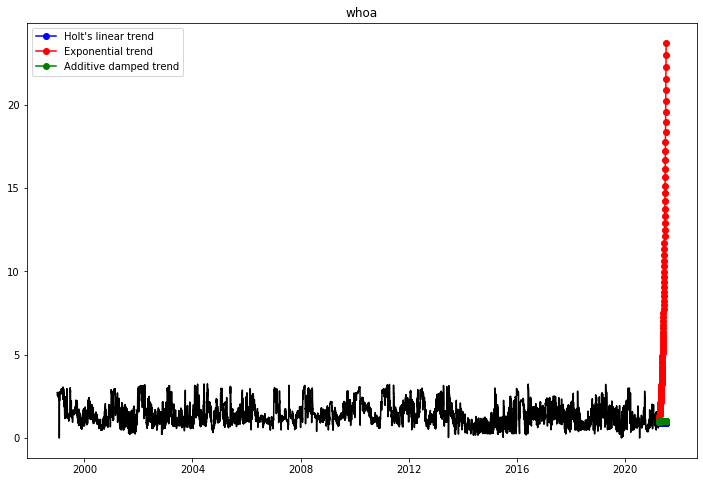

In [24]:
# modified from tutorial for Holt's method from webiste above

pred_length = 100

#train/test split
train = df.iloc[:-pred_length,:]
test = df.iloc[-pred_length:, :]

# getting input data into format function can understand
data = list(train['energy_generated'])
date_info = train['date'].copy()
date_info.name = None
index= pd.to_datetime(date_info,format = '%Y/%m/%d')
data = pd.Series(data, index)

# these are parameters we can play with
alpha = 0.8
beta = 0.2

# fitting methods
# holt linear trend, no damping term
fit1 = Holt(data, initialization_method="estimated").fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)
fcast1 = fit1.forecast(pred_length).rename("Holt's linear trend")

# holt exponential trend
fit2 = Holt(data + 0.001, exponential=True, initialization_method="estimated").fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)
fcast2 = fit2.forecast(pred_length).rename("Exponential trend")

# holt linear trend damped, damping coefficient optimized
fit3 = Holt(data, damped_trend=True, initialization_method="estimated").fit(smoothing_level=alpha, smoothing_trend=beta)
fcast3 = fit3.forecast(pred_length).rename("Additive damped trend")

#plotting stuff
plt.figure(figsize=(12, 8))
plt.plot(data, color='black')
#plt.plot(fit1.fittedvalues, marker='o', color='blue')
line1, = plt.plot(fcast1, marker='o', color='blue')
#plt.plot(fit2.fittedvalues, marker='o', color='red')
line2, = plt.plot(fcast2, marker='o', color='red')
#plt.plot(fit3.fittedvalues, marker='o', color='green')
line3, = plt.plot(fcast3, marker='o', color='green')
plt.title('whoa')
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

print('We are predicting %s days in advance' %pred_length)

mae1 = mean_absolute_error(fcast1,test['energy_generated'])
rmse1 = mean_squared_error(fcast1,test['energy_generated'], squared=False)
print('MAE of Holt linear is %s' %mae1, ' and RMSE is %s' %rmse1)

mae2 = mean_absolute_error(fcast2,test['energy_generated'])
rmse2 = mean_squared_error(fcast2,test['energy_generated'], squared=False)
print('MAE of Holt exponential %s' %mae2, ' and RMSE is %s' %rmse2)

mae3 = mean_absolute_error(fcast3,test['energy_generated'])
rmse3 = mean_squared_error(fcast3,test['energy_generated'], squared=False)
print('MAE of Holt with damping is %s' %mae3, ' and RMSE is %s' %rmse3)



There's a lot of parameter's in Holt's model so I'm gonna play around with them a bit.  Also want to see if I can optimize multiple parameter selection.

Deleting exponential trend because that is nonsense for long predictions

/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


We are predicting 7 days in advance
MAE of Holt linear is 0.05454954417733054  and RMSE is 0.05976085414498914
MAE of Holt with damping is 0.015185296744352261  and RMSE is 0.015854853858002834


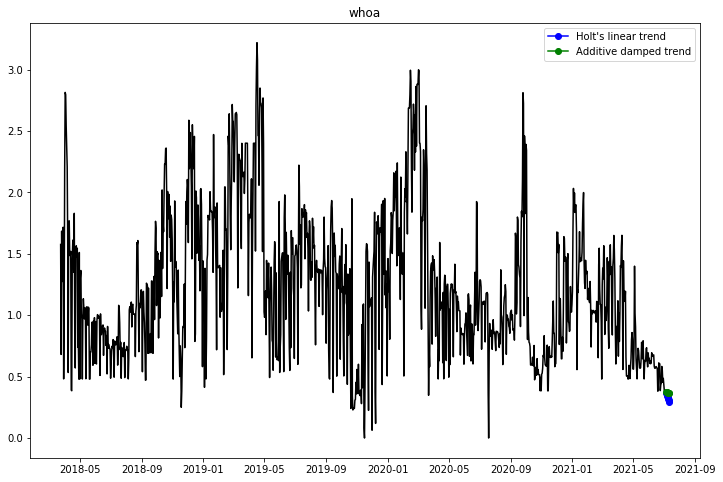

In [25]:
# modified from tutorial for Holt's method from webiste above

pred_length = 7

#train/test split
train = df.iloc[:-pred_length,:]
test = df.iloc[-pred_length:, :]

# getting input data into format function can understand
data = list(train['energy_generated'])
date_info = train['date'].copy()
date_info.name = None
index= pd.to_datetime(date_info,format = '%Y/%m/%d')
data = pd.Series(data, index)

# these are parameters we can play with
alpha = 0.7
beta = 0.2

# fitting methods
# holt linear trend, no damping term
fit1 = Holt(data, initialization_method="estimated").fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)
fcast1 = fit1.forecast(pred_length).rename("Holt's linear trend")

# optimizing holt---didn't work any better than alpha = .8, beta = .2, which was arbitrary from the tutorial notebook
# fit1 = Holt(data, initialization_method="estimated").fit(optimized=True)
# fcast1 = fit1.forecast(pred_length).rename("Holt's linear trend")

# holt linear trend damped, damping coefficient optimized
fit3 = Holt(data, damped_trend=True, initialization_method="estimated").fit(smoothing_level=alpha, smoothing_trend=beta)
fcast3 = fit3.forecast(pred_length).rename("Additive damped trend")

#plotting stuff

# whole interval looks messy, we can narrow it with this parameter
view_length = 1200

plt.figure(figsize=(12, 8))
plt.plot(data[-view_length:], color='black')
#plt.plot(fit1.fittedvalues, marker='o', color='blue')
line1, = plt.plot(fcast1, marker='o', color='blue')
#plt.plot(fit3.fittedvalues, marker='o', color='green')
line3, = plt.plot(fcast3, marker='o', color='green')
plt.title('whoa')
plt.legend([line1, line3], [fcast1.name, fcast3.name])

print('We are predicting %s days in advance' %pred_length)

mae1 = mean_absolute_error(fcast1,test['energy_generated'])
rmse1 = mean_squared_error(fcast1,test['energy_generated'], squared=False)
print('MAE of Holt linear is %s' %mae1, ' and RMSE is %s' %rmse1)


mae3 = mean_absolute_error(fcast3,test['energy_generated'])
rmse3 = mean_squared_error(fcast3,test['energy_generated'], squared=False)
print('MAE of Holt with damping is %s' %mae3, ' and RMSE is %s' %rmse3)





Thus far, from experimenting, the best parameter choices I have found are:

$\alpha = 0.7$

$\beta = 0.2$

Let's build a for loop and see if we can beat that

In [26]:
# # This loop is commented out because it makes no sense (cheating and looking at future) and also it takes WAAAAAAAAYYYYY too long to run

# # modified from tutorial for Holt's method from webiste above
# pred_length = 100

# #train/test split
# train = df.iloc[:-pred_length,:]
# test = df.iloc[-pred_length:, :]

# # getting input data into format function can understand
# data = list(train['energy_generated'])
# date_info = train['date'].copy()
# date_info.name = None
# index= pd.to_datetime(date_info,format = '%Y/%m/%d')
# data = pd.Series(data, index)

# # initializing parameter possibilities
# alpha = np.linspace(0,1,101)
# beta = np.linspace(0,1,101)

# # gonna save the best ones as these variables
# bestalpha = 0
# bestbeta = 0
# bestmae = .4

# for alph in alpha:
#     for bet in beta:
#         # holt linear trend, no damping term
#         fit1 = Holt(data, initialization_method="estimated").fit(smoothing_level=alph, smoothing_trend=bet, optimized=False)
#         fcast1 = fit1.forecast(pred_length).rename("Holt's linear trend")
#         # computing MAE
#         mae1 = mean_absolute_error(fcast1,test['energy_generated'])
#         if mae1 < bestmae:
#             bestalpha = alph
#             bestbeta = bet
#             bestmae = mae1
# #             print('alpha is %s' %alph)
# #             print('beta is %s' %bet)
# #             print('mae is %s' %mae1)







I forgot to print the results of this huge double for loop (took a long ass time to run) but for the record the best are

$\alpha = 0.66$

$\beta = 0.21$

mae$=0.1410953301793883$

Gonna plot these optimized values below:

/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


We are predicting 100 days in advance
MAE of Holt linear is 0.1410953301793883  and RMSE is 0.209070423723769
MAE of Holt with damping is 0.38756573123051524  and RMSE is 0.4117221695242913


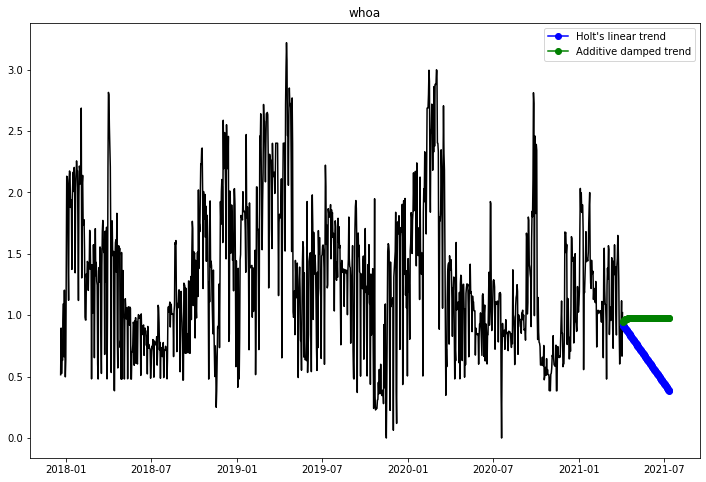

In [27]:
# modified from tutorial for Holt's method from webiste above

pred_length = 100

#train/test split
train = df.iloc[:-pred_length,:]
test = df.iloc[-pred_length:, :]

# getting input data into format function can understand
data = list(train['energy_generated'])
date_info = train['date'].copy()
date_info.name = None
index= pd.to_datetime(date_info,format = '%Y/%m/%d')
data = pd.Series(data, index)

# these are parameters we can play with
alpha = 0.66
beta = 0.21

# fitting methods
# holt linear trend, no damping term
fit1 = Holt(data, initialization_method="estimated").fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)
fcast1 = fit1.forecast(pred_length).rename("Holt's linear trend")

# optimizing holt---didn't work any better than alpha = .8, beta = .2, which was arbitrary from the tutorial notebook
# fit1 = Holt(data, initialization_method="estimated").fit(optimized=True)
# fcast1 = fit1.forecast(pred_length).rename("Holt's linear trend")

# holt linear trend damped, damping coefficient optimized
fit3 = Holt(data, damped_trend=True, initialization_method="estimated").fit(smoothing_level=alpha, smoothing_trend=beta)
fcast3 = fit3.forecast(pred_length).rename("Additive damped trend")

#plotting stuff

# whole interval looks messy, we can narrow it with this parameter
view_length = 1200

plt.figure(figsize=(12, 8))
plt.plot(data[-view_length:], color='black')
#plt.plot(fit1.fittedvalues, marker='o', color='blue')
line1, = plt.plot(fcast1, marker='o', color='blue')
#plt.plot(fit3.fittedvalues, marker='o', color='green')
line3, = plt.plot(fcast3, marker='o', color='green')
plt.title('whoa')
plt.legend([line1, line3], [fcast1.name, fcast3.name])

print('We are predicting %s days in advance' %pred_length)

mae1 = mean_absolute_error(fcast1,test['energy_generated'])
rmse1 = mean_squared_error(fcast1,test['energy_generated'], squared=False)
print('MAE of Holt linear is %s' %mae1, ' and RMSE is %s' %rmse1)


mae3 = mean_absolute_error(fcast3,test['energy_generated'])
rmse3 = mean_squared_error(fcast3,test['energy_generated'], squared=False)
print('MAE of Holt with damping is %s' %mae3, ' and RMSE is %s' %rmse3)





The above model shows that Holt has some potential.  However, the parameter choice that I used I got by cheating (test MAE used for selection, not sure where my brain went).

To get a more realistic idea of how this model might perform, let's try the built-in optimizers and cross validation.  

/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


We are predicting 100 days in advance
alpha is 0.6303439334823056
beta* is 0.0
MAE of Holt linear is 0.3484544743265174  and RMSE is 0.37302989110427237


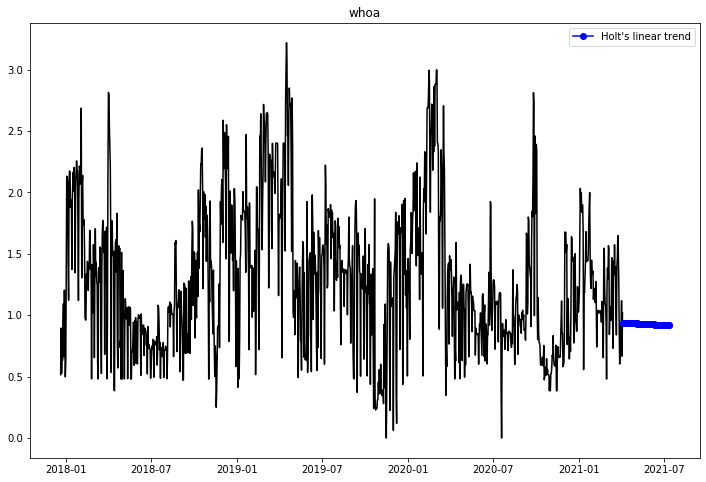

In [28]:
# modified from tutorial for Holt's method from webiste above

pred_length = 100

#train/test split
train = df.iloc[:-pred_length,:]
test = df.iloc[-pred_length:, :]

# getting input data into format function can understand
data = list(train['energy_generated'])
date_info = train['date'].copy()
date_info.name = None
index= pd.to_datetime(date_info,format = '%Y/%m/%d')
data = pd.Series(data, index)


# fitting methods
# holt linear trend, no damping term
# parameters chosen via optimization
fit1 = Holt(data, initialization_method="estimated").fit(optimized=True)
# alternatively, we can choose one parameter and optimize the other:
#fit1 = Holt(data, initialization_method="estimated").fit(smoothing_trend = .2, optimized=True)
fcast1 = fit1.forecast(pred_length).rename("Holt's linear trend")

#plotting stuff

# whole interval looks messy, we can narrow it with this parameter
# note that this window only changes the plot--the model is built with more data than this
view_length = 1200

plt.figure(figsize=(12, 8))
plt.plot(data[-view_length:], color='black')
# plt.plot(fit1.fittedvalues, color='blue')
line1, = plt.plot(fcast1, marker='o', color='blue')

plt.title('whoa')
plt.legend([line1], [fcast1.name])

print('We are predicting %s days in advance' %pred_length)
print('alpha is %s' %fit1.model.params['smoothing_level'])
print('beta* is %s' %fit1.model.params['smoothing_trend'])

mae1 = mean_absolute_error(fcast1,test['energy_generated'])
rmse1 = mean_squared_error(fcast1,test['energy_generated'], squared=False)
print('MAE of Holt linear is %s' %mae1, ' and RMSE is %s' %rmse1)

Let's check out what happens if we do Holt linear optimized but only use the last few years of data

/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


We are predicting 100 days in advance
alpha is 0.44457543782515696
beta* is 0.0
MAE of Holt linear is 0.2782556826310156  and RMSE is 0.3063347035396055


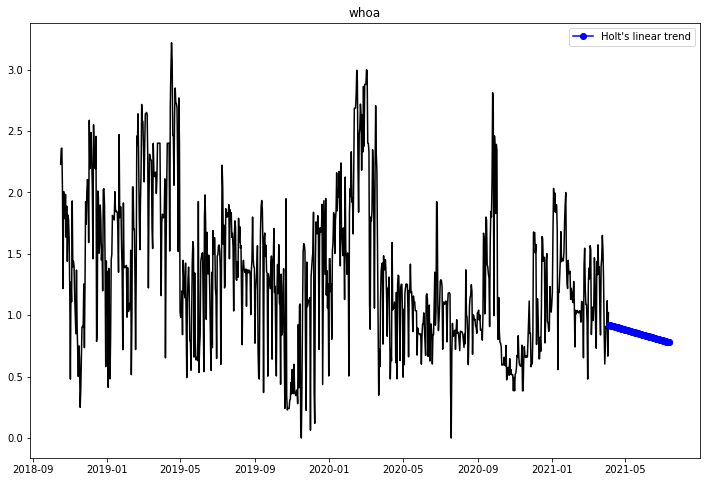

In [29]:
# modified from tutorial for Holt's method from webiste above

pred_length = 100

df2 = df.iloc[-1000:,:]

#train/test split
train = df2.iloc[:-pred_length,:]
test = df2.iloc[-pred_length:, :]

# getting input data into format function can understand
data = list(train['energy_generated'])
date_info = train['date'].copy()
date_info.name = None
index= pd.to_datetime(date_info,format = '%Y/%m/%d')
data = pd.Series(data, index)


# fitting methods
# holt linear trend, no damping term
# parameters chosen via optimization
fit1 = Holt(data, initialization_method="estimated").fit(optimized=True)
# alternatively, we can choose one parameter and optimize the other:
#fit1 = Holt(data, initialization_method="estimated").fit(smoothing_trend = .2, optimized=True)
fcast1 = fit1.forecast(pred_length).rename("Holt's linear trend")

#plotting stuff

# whole interval looks messy, we can narrow it with this parameter
# note that this window only changes the plot--the model is built with more data than this
view_length = 1200

plt.figure(figsize=(12, 8))
plt.plot(data[-view_length:], color='black')
# plt.plot(fit1.fittedvalues, color='blue')
line1, = plt.plot(fcast1, marker='o', color='blue')

plt.title('whoa')
plt.legend([line1], [fcast1.name])

print('We are predicting %s days in advance' %pred_length)
print('alpha is %s' %fit1.model.params['smoothing_level'])
print('beta* is %s' %fit1.model.params['smoothing_trend'])

mae1 = mean_absolute_error(fcast1,test['energy_generated'])
rmse1 = mean_squared_error(fcast1,test['energy_generated'], squared=False)
print('MAE of Holt linear is %s' %mae1, ' and RMSE is %s' %rmse1)

Above kinda works, maybe worth using (built by identifying trend windows with standard additive decomposition)

Ok, now I'm gonna actually do some time series cross validation

In [30]:
from sklearn.model_selection import TimeSeriesSplit

In [45]:
# size of prediction window
pred_length = 100
# tell us how many days we are predicting
print('We are predicting %s days in advance' %pred_length)
# number of cross-validtion splits to do
cross_splits = 11
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df['energy_generated']

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    # Holt on training set
    # parameters chosen via optimization
    fit1 = Holt(data, initialization_method="estimated").fit(optimized=True)
    fcast1 = fit1.forecast(pred_length).rename("Holt's linear trend")
    # printing parameters and MAE
#     print('alpha is %s' %fit1.model.params['smoothing_level'])
#     print('beta* is %s' %fit1.model.params['smoothing_trend'])
    mae = mean_absolute_error(fcast1,y_test)
#     print('MAE of Holt linear is %s' %mae)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print(np.mean(mae_list))

We are predicting 100 days in advance


/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency inf

[0.3283415891691812, 0.7751725708817978, 1.1236438751741107, 0.5645984391594696, 0.4706920920266595, 0.9121610797412514, 0.48047194820032774, 0.22317944604744294, 0.4085821851468243, 0.41218527612065636, 0.2782556826310156]
0.5433894712998852


/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


above demonstrates that MAE for Holt is actually pretty high... let's add a damping term!

In [47]:
# size of prediction window
pred_length = 100
# tell us how many days we are predicting
print('We are predicting %s days in advance' %pred_length)
# number of cross-validtion splits to do
cross_splits = 11
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df['energy_generated']

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    # Holt on training set
    # parameters chosen via optimization
    fit1 = Holt(data, damped_trend = True, initialization_method="estimated").fit(optimized=True)
    fcast1 = fit1.forecast(pred_length).rename("Holt's linear trend")
    # printing parameters and MAE
#     print('alpha is %s' %fit1.model.params['smoothing_level'])
#     print('beta* is %s' %fit1.model.params['smoothing_trend'])
    mae = mean_absolute_error(fcast1,y_test)
#     print('MAE of Holt linear is %s' %mae)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print(np.mean(mae_list))

We are predicting 100 days in advance


/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency inf

[0.29531351029363445, 0.7264284652143305, 1.0535374041882641, 0.5110460948143438, 0.4721778554403964, 0.8466034014680603, 0.44932220573401466, 0.1990873027202007, 0.42488035577285904, 0.36069715874784597, 0.3466837948920248]
0.5168888681169068


/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


I guess damping term didn't do too much